# Identity Document Classification using Custom CNN

This notebook walks through the process of training a custom CNN model to classify identity documents by country of origin.

Our dataset consists of segmented images of identity documents from 10 different countries, extracted using a YOLO instance segmentation model.

## 1. Setup and Imports

In [2]:
import os
import sys
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import cv2

# Add current directory to path to import local modules
sys.path.append('.')

# Import custom modules
from dataset import load_data, get_transforms
from models import CustomCNNModel
from train import train_model, evaluate_model, visualize_training_history, model_summary, visualize_misclassified_samples

import wandb

# Set the random seed for reproducibility
SEED = 43
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

c:\Users\zerad\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU
CUDA Version: 12.1
Memory: 8.59 GB


## 2. Configuration

Let's set up the configuration parameters for our training. These parameters align with the arguments in `run_training.py`.

In [4]:
# Data parameters
DATA_DIR = '../../data/cropped_images'
IMG_SIZE = 224
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
BATCH_SIZE = 64
NUM_WORKERS = 4

# Training parameters
EPOCHS = 100 
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4  # L2 regularization
PATIENCE = 7
CHECKPOINT_DIR = Path('../../web-app/backend/models')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

## 3. Data Loading and Exploration

Now let's load our data and explore it to understand what we're working with.

In [5]:
# Load the data
data = load_data(
    data_dir=DATA_DIR,
    img_size=IMG_SIZE,
    val_split=VAL_SPLIT,
    test_split=TEST_SPLIT,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    seed=SEED
)

# Get class names
class_names = data['class_names']
num_classes = data['num_classes']

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Dataset split: 700 training, 150 validation, 150 test
alb_id: 70 train, 15 val, 15 test
aze_passport: 70 train, 15 val, 15 test
esp_id: 70 train, 15 val, 15 test
est_id: 70 train, 15 val, 15 test
fin_id: 70 train, 15 val, 15 test
grc_passport: 70 train, 15 val, 15 test
lva_passport: 70 train, 15 val, 15 test
rus_internalpassport: 70 train, 15 val, 15 test
srb_passport: 70 train, 15 val, 15 test
svk_id: 70 train, 15 val, 15 test
Number of classes: 10
Class names: ['alb_id', 'aze_passport', 'esp_id', 'est_id', 'fin_id', 'grc_passport', 'lva_passport', 'rus_internalpassport', 'srb_passport', 'svk_id']


c:\Users\zerad\Desktop\Sujan\PassportPAL\notebooks\classifier\dataset.py:76: UserWarning: Argument(s) 'mean, std' are not valid for transform GaussNoise
  A.GaussNoise(mean=0, std=(0.01, 0.05), p=0.3),  # Add noise


## 4. Saving Dataset

In [7]:
import shutil

def save_dataset_split(image_paths, labels, class_names, base_dir='../../data/final_classification_dataset', split='train'):
    """
    Copies images corresponding to a particular split (train/val/test) into
    'final_classification_dataset/<split>/<class_name>/' folders.

    Args:
        image_paths (list): List of image file paths.
        labels (list): Corresponding list of integer labels.
        class_names (list): List of all class names (indexed by label).
        base_dir (str): Base directory where to save the split.
        split (str): One of 'train', 'val', or 'test'.
    """
    split_dir = os.path.join(base_dir, split)
    # Create split folder and subfolders
    for c in class_names:
        os.makedirs(os.path.join(split_dir, c), exist_ok=True)

    print(f"Saving {split} data into '{split_dir}' ...")
    for img_path, label in zip(image_paths, labels):
        class_name = class_names[label]
        dst_dir = os.path.join(split_dir, class_name)
        # Copy the file
        shutil.copy2(img_path, os.path.join(dst_dir, os.path.basename(img_path)))
    print(f"Finished saving {split} set. Total images: {len(image_paths)}")

In [9]:
 # Save the train, val, and test sets to 'final_classification_dataset'
    # data['train_dataset'].image_paths and data['train_dataset'].labels
if data['train_dataset'] is not None:
    save_dataset_split(
        image_paths=data['train_dataset'].image_paths,
        labels=data['train_dataset'].labels,
        class_names=class_names,
        base_dir='../../data/final_classification_dataset',
        split='train'
    )
if data['val_dataset'] is not None:
    save_dataset_split(
        image_paths=data['val_dataset'].image_paths,
        labels=data['val_dataset'].labels,
        class_names=class_names,
        base_dir='../../data/final_classification_dataset',
        split='val'
    )
if data['test_dataset'] is not None:
    save_dataset_split(
        image_paths=data['test_dataset'].image_paths,
        labels=data['test_dataset'].labels,
        class_names=class_names,
        base_dir='../../data/final_classification_dataset',
        split='test'
    )


Saving train data into '../../data/final_classification_dataset\train' ...
Finished saving train set. Total images: 700
Saving val data into '../../data/final_classification_dataset\val' ...
Finished saving val set. Total images: 150
Saving test data into '../../data/final_classification_dataset\test' ...
Finished saving test set. Total images: 150


# Sample Visualization of each data split

In [10]:
def visualize_original_samples(dataset, class_names, num_images=5, title="Samples"):
    """
    Visualize original samples from a dataset without any transformations.
    
    Args:
        dataset: PyTorch dataset object
        class_names (list): List of class names
        num_images (int): Number of images to display
        figsize (tuple): Figure size
    """
    # Select random indices
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    # Create figure
    fig, axes = plt.subplots(1, num_images, figsize=(4 * num_images, 4))
    fig.suptitle(title, fontsize=16)
    
    for i, idx in enumerate(indices):
        # Get image path and label directly from dataset
        img_path = dataset.image_paths[idx]
        label = dataset.labels[idx]
        
        # Load original image without transformations
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Display image
        axes[i].imshow(image)
        axes[i].set_title(f"Class: {class_names[label]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

Visualizing sample images from the TRAIN set:


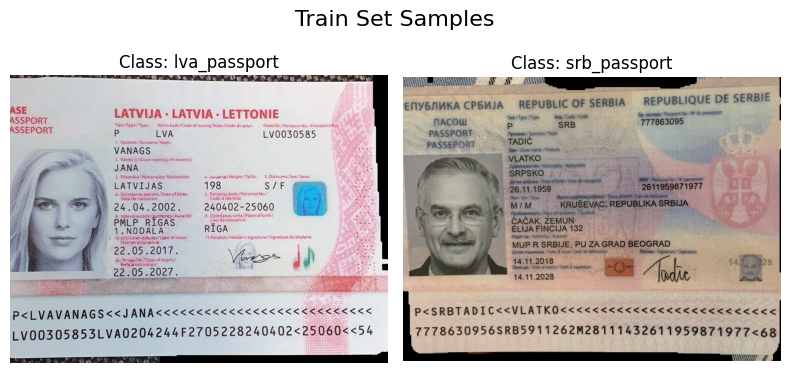

Visualizing sample images from the VALIDATION set:


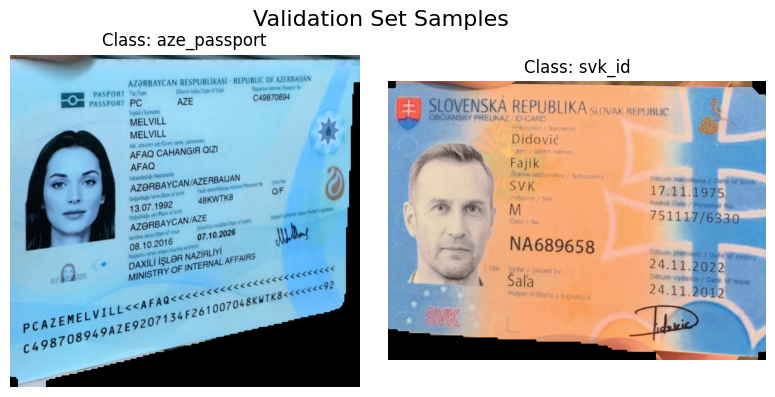

Visualizing sample images from the TEST set:


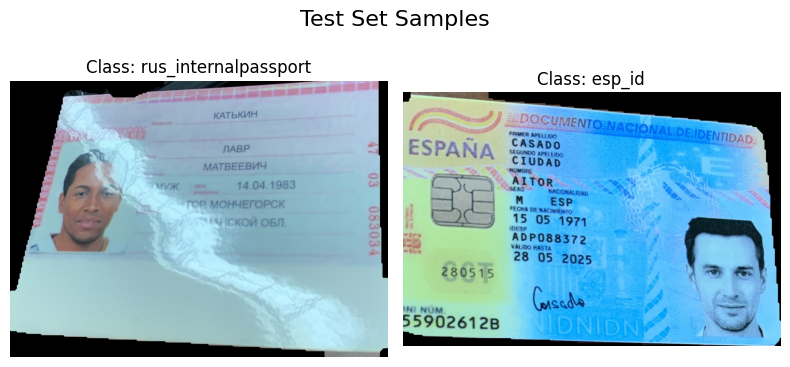

In [11]:

def visualize_small_samples_from_splits(data, class_names, num_images=2):
    """
    Show a small number of samples (num_images) from each of the
    train, val, and test sets before training.
    """
    if data['train_dataset'] is not None:
        print("Visualizing sample images from the TRAIN set:")
        visualize_original_samples(data['train_dataset'], class_names, num_images, title="Train Set Samples")

    if data['val_dataset'] is not None:
        print("Visualizing sample images from the VALIDATION set:")
        visualize_original_samples(data['val_dataset'], class_names, num_images, title="Validation Set Samples")

    if data['test_dataset'] is not None:
        print("Visualizing sample images from the TEST set:")
        visualize_original_samples(data['test_dataset'], class_names, num_images, title="Test Set Samples")

# Show 2 samples from each split
visualize_small_samples_from_splits(data, class_names, num_images=2)

Augmentation examples:


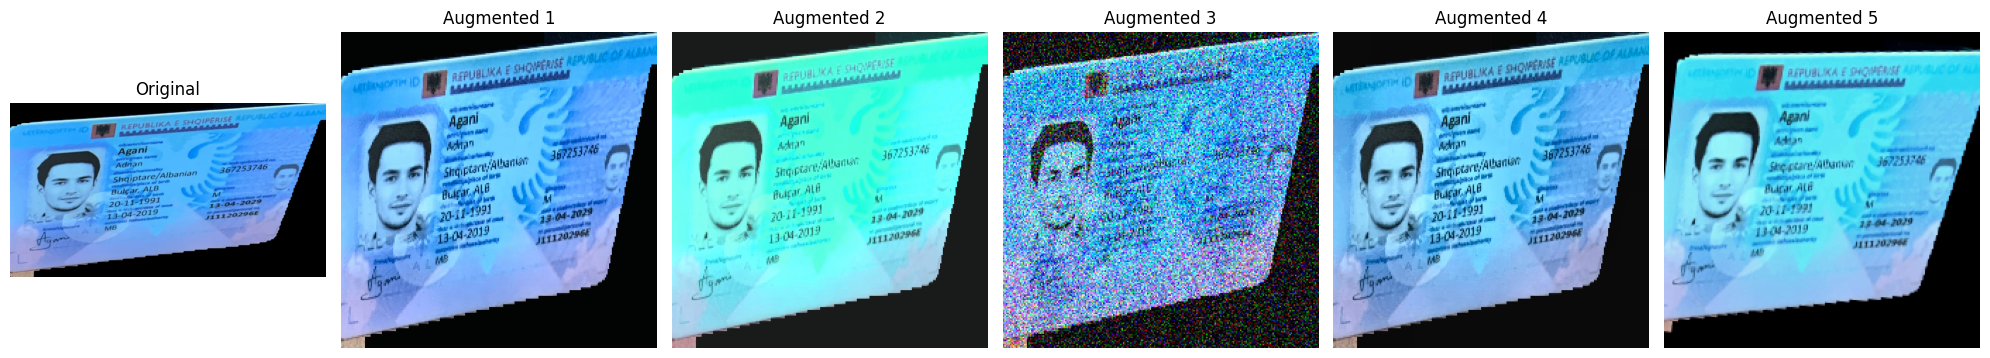

In [ ]:
def visualize_augmentation_pipeline(image_path, transform, num_samples=5, figsize=(20, 10)):
    """
    Visualize how augmentation affects a single image.
    
    Args:
        image_path (str): Path to the image
        transform: Transformation pipeline
        num_samples (int): Number of augmented samples to generate
        figsize (tuple): Figure size
    """
    # Load original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Create figure
    fig, axes = plt.subplots(1, num_samples + 1, figsize=figsize)
    
    # Display original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # Generate and display augmented images
    for i in range(num_samples):
        # Apply transformations (excluding normalization and ToTensorV2 for visualization)
        augmented = transform(image=original_image.copy())
        augmented_image = augmented['image']
        
        if torch.is_tensor(augmented_image):
            # Convert tensor back to numpy for visualization
            augmented_image = augmented_image.permute(1, 2, 0).numpy()
            # Denormalize if needed
            augmented_image = augmented_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            augmented_image = np.clip(augmented_image, 0, 1)
        
        # Display augmented image
        axes[i+1].imshow(augmented_image)
        axes[i+1].set_title(f"Augmented {i+1}")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Get a sample image path from the first class
sample_class_dir = os.path.join(DATA_DIR, class_names[0])
sample_image_path = os.path.join(sample_class_dir, os.listdir(sample_class_dir)[0])

# Get the transformation pipeline (training transforms with augmentation)
transforms_dict = get_transforms(img_size=IMG_SIZE, use_augmentation=True)
train_transform = transforms_dict['train']

# Visualize augmentation pipeline
print("Augmentation examples:")
visualize_augmentation_pipeline(sample_image_path, train_transform)

## 6. Model Architecture

Now let's create our custom CNN model and examine its architecture.

In [15]:
# Create the model
model = CustomCNNModel(num_classes=num_classes)
model.to(device)

# Print model summary
model_summary(model)

# Define loss function, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

CustomCNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc_bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_bn2): 

In [16]:
import wandb

# Initialize wandb
wandb.init(project="PassportPAL-Classifier", name="Custom_CNN", config={
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "architecture": "Custom_CNN",
})

# Log model architecture
wandb.watch(model, log="all")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: wisewizer to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 7. Training the Model

Now we'll train our custom CNN model on the dataset. The training function handles both training and validation, and includes early stopping to prevent overfitting.

In [17]:
# Generate a unique model name with timestamp
from datetime import datetime
model_name = f"custom_cnn_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# Train the model
model, history = train_model(
    model=model,
    dataloaders={
        'train': data['train_loader'],
        'val': data['val_loader']
    },
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=EPOCHS,
    device=device,
    save_dir=CHECKPOINT_DIR,
    model_name=model_name,
    early_stopping_patience=PATIENCE
)

Epoch 1/100
----------


train: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


train Loss: 2.1631 Acc: 0.2329


val: 100%|██████████| 3/3 [00:07<00:00,  2.63s/it]


val Loss: 2.0294 Acc: 0.2533

Epoch 2/100
----------


train: 100%|██████████| 11/11 [00:25<00:00,  2.27s/it]


train Loss: 1.6554 Acc: 0.4214


val: 100%|██████████| 3/3 [00:07<00:00,  2.57s/it]


val Loss: 1.5397 Acc: 0.5800

Epoch 3/100
----------


train: 100%|██████████| 11/11 [00:24<00:00,  2.20s/it]


train Loss: 1.2927 Acc: 0.6000


val: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it]


val Loss: 1.2004 Acc: 0.6933

Epoch 4/100
----------


train: 100%|██████████| 11/11 [00:24<00:00,  2.26s/it]


train Loss: 1.0078 Acc: 0.7143


val: 100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


val Loss: 0.6742 Acc: 0.8267

Epoch 5/100
----------


train: 100%|██████████| 11/11 [00:25<00:00,  2.33s/it]


train Loss: 0.7568 Acc: 0.8029


val: 100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


val Loss: 0.4259 Acc: 0.9200

Epoch 6/100
----------


train: 100%|██████████| 11/11 [00:24<00:00,  2.21s/it]


train Loss: 0.5518 Acc: 0.8629


val: 100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


val Loss: 0.2890 Acc: 0.9533

Epoch 7/100
----------


train: 100%|██████████| 11/11 [00:25<00:00,  2.28s/it]


train Loss: 0.4713 Acc: 0.8900


val: 100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


val Loss: 0.2561 Acc: 0.9533

Epoch 8/100
----------


train: 100%|██████████| 11/11 [00:24<00:00,  2.21s/it]


train Loss: 0.3769 Acc: 0.9057


val: 100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


val Loss: 0.1759 Acc: 0.9667

Epoch 9/100
----------


train: 100%|██████████| 11/11 [00:24<00:00,  2.22s/it]


train Loss: 0.2988 Acc: 0.9357


val: 100%|██████████| 3/3 [00:07<00:00,  2.57s/it]


val Loss: 0.1342 Acc: 0.9733

Epoch 10/100
----------


train: 100%|██████████| 11/11 [00:24<00:00,  2.19s/it]


train Loss: 0.2711 Acc: 0.9357


val: 100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


val Loss: 0.1046 Acc: 0.9800

Epoch 11/100
----------


train: 100%|██████████| 11/11 [00:23<00:00,  2.18s/it]


train Loss: 0.2510 Acc: 0.9386


val: 100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


val Loss: 0.0894 Acc: 0.9933

Epoch 12/100
----------


train: 100%|██████████| 11/11 [00:24<00:00,  2.19s/it]


train Loss: 0.2075 Acc: 0.9543


val: 100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


val Loss: 0.1295 Acc: 0.9533

Epoch 13/100
----------


train: 100%|██████████| 11/11 [00:23<00:00,  2.17s/it]


train Loss: 0.1969 Acc: 0.9514


val: 100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


val Loss: 0.0705 Acc: 0.9933

Epoch 14/100
----------


train: 100%|██████████| 11/11 [00:23<00:00,  2.16s/it]


train Loss: 0.1562 Acc: 0.9714


val: 100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


val Loss: 0.0626 Acc: 0.9867

Epoch 15/100
----------


train: 100%|██████████| 11/11 [00:24<00:00,  2.19s/it]


train Loss: 0.1502 Acc: 0.9700


val: 100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


val Loss: 0.0794 Acc: 0.9867

Epoch 16/100
----------


train: 100%|██████████| 11/11 [00:24<00:00,  2.20s/it]


train Loss: 0.1549 Acc: 0.9614


val: 100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


val Loss: 0.0701 Acc: 0.9800

Epoch 17/100
----------


train: 100%|██████████| 11/11 [00:24<00:00,  2.20s/it]


train Loss: 0.1624 Acc: 0.9600


val: 100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


val Loss: 0.0433 Acc: 0.9867

Epoch 18/100
----------


train: 100%|██████████| 11/11 [00:23<00:00,  2.17s/it]


train Loss: 0.1221 Acc: 0.9729


val: 100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


val Loss: 0.0388 Acc: 1.0000

Epoch 19/100
----------


train: 100%|██████████| 11/11 [00:23<00:00,  2.17s/it]


train Loss: 0.1361 Acc: 0.9614


val: 100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


val Loss: 0.0271 Acc: 1.0000

Epoch 20/100
----------


train: 100%|██████████| 11/11 [00:24<00:00,  2.27s/it]


train Loss: 0.1075 Acc: 0.9714


val: 100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


val Loss: 0.0476 Acc: 0.9800

Epoch 21/100
----------


train: 100%|██████████| 11/11 [00:24<00:00,  2.23s/it]


train Loss: 0.0993 Acc: 0.9800


val: 100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


val Loss: 0.0246 Acc: 1.0000

Epoch 22/100
----------


train: 100%|██████████| 11/11 [00:24<00:00,  2.26s/it]


train Loss: 0.1029 Acc: 0.9800


val: 100%|██████████| 3/3 [00:07<00:00,  2.57s/it]


val Loss: 0.0274 Acc: 1.0000

Epoch 23/100
----------


train: 100%|██████████| 11/11 [00:24<00:00,  2.22s/it]


train Loss: 0.1088 Acc: 0.9714


val: 100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


val Loss: 0.0173 Acc: 1.0000

Epoch 24/100
----------


train: 100%|██████████| 11/11 [00:24<00:00,  2.24s/it]


train Loss: 0.1019 Acc: 0.9714


val: 100%|██████████| 3/3 [00:07<00:00,  2.62s/it]


val Loss: 0.0372 Acc: 0.9933

Epoch 25/100
----------


train: 100%|██████████| 11/11 [00:24<00:00,  2.23s/it]


train Loss: 0.0816 Acc: 0.9829


val: 100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


val Loss: 0.0328 Acc: 0.9933
Early stopping triggered after 25 epochs
Training complete in 13m 30s
Best val Acc: 1.0000 at epoch 18


## 8. Visualizing Training Results

Let's visualize our training history to see how the model performed over time.

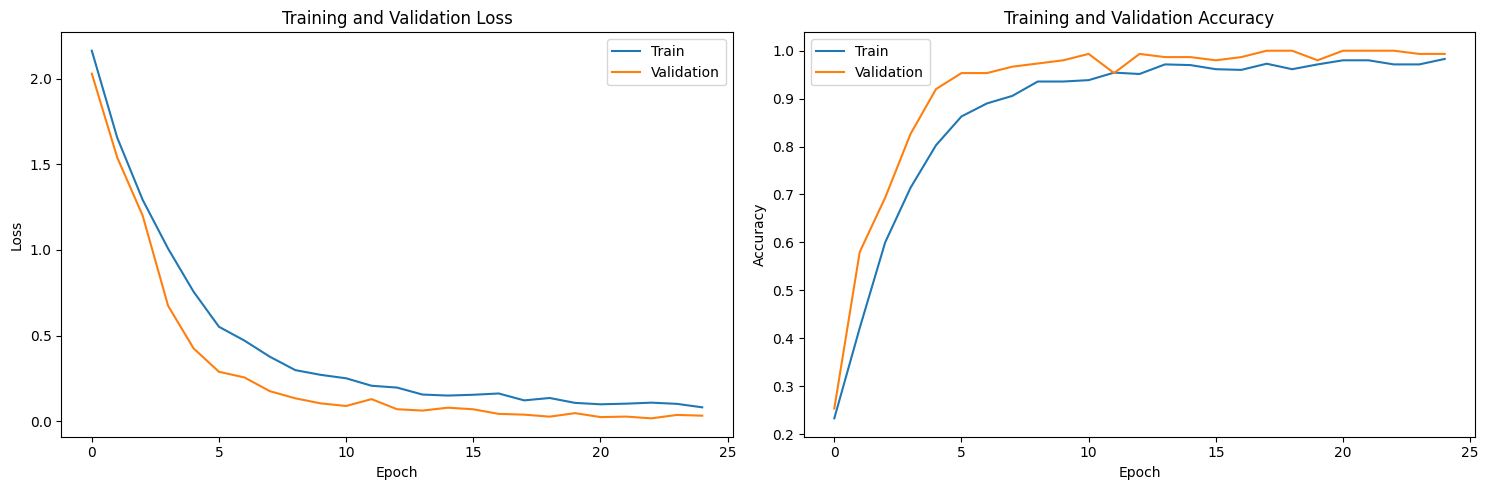

In [18]:
# Visualize training history
visualize_training_history(history)

## 9. Model Evaluation

Now let's evaluate our trained model on the test set to see how well it generalizes to unseen data.

Evaluating: 100%|██████████| 3/3 [00:07<00:00,  2.62s/it]

Accuracy: 0.9867
Precision: 0.9875
Recall: 0.9867
F1 Score: 0.9867

Classification Report:
                      precision    recall  f1-score   support

              alb_id       1.00      1.00      1.00        15
        aze_passport       1.00      1.00      1.00        15
              esp_id       0.94      1.00      0.97        15
              est_id       1.00      1.00      1.00        15
              fin_id       1.00      0.93      0.97        15
        grc_passport       1.00      1.00      1.00        15
        lva_passport       1.00      0.93      0.97        15
rus_internalpassport       1.00      1.00      1.00        15
        srb_passport       0.94      1.00      0.97        15
              svk_id       1.00      1.00      1.00        15

            accuracy                           0.99       150
           macro avg       0.99      0.99      0.99       150
        weighted avg       0.99      0.99      0.99       150



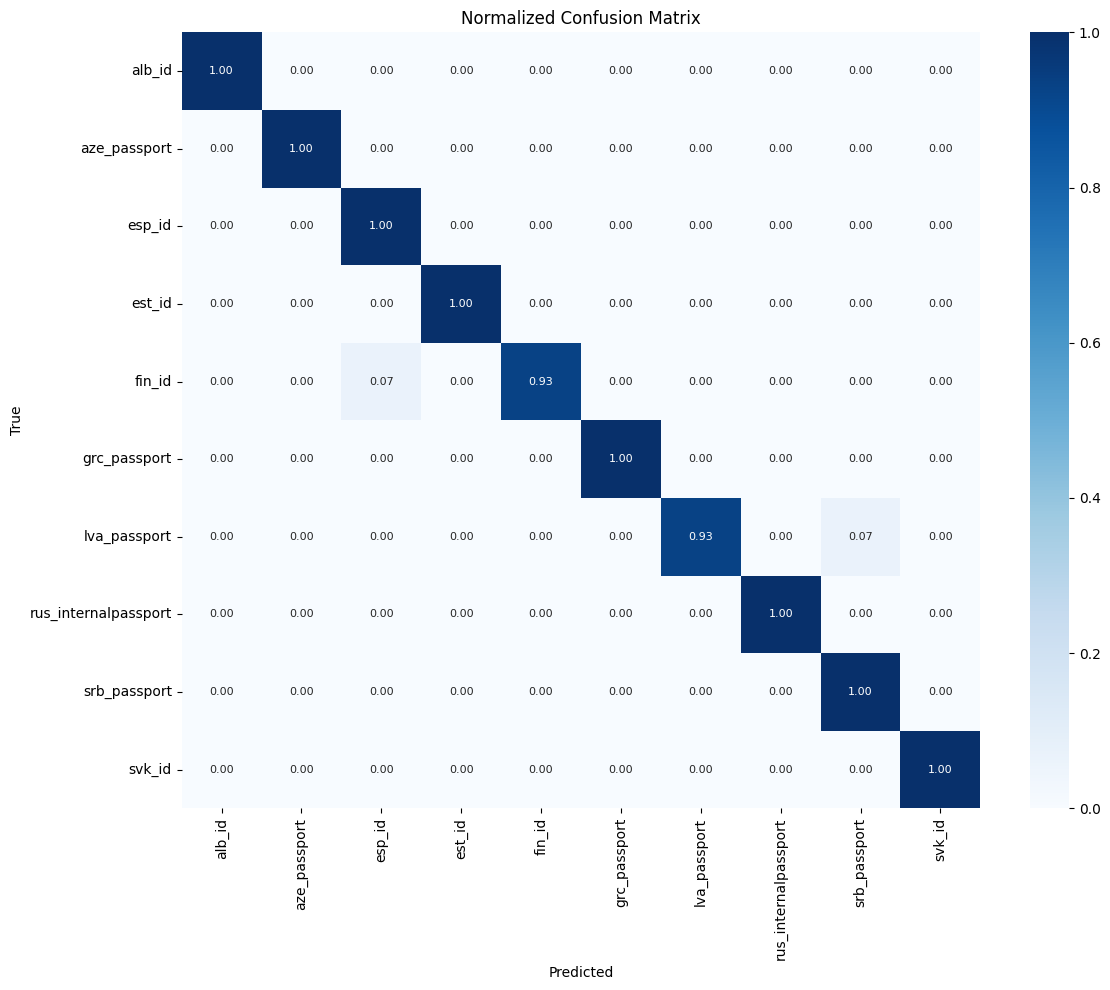

In [19]:
# Evaluate the model on the test set
test_metrics = evaluate_model(model, data['test_loader'], device, class_names)

In [20]:
# Log test metrics to wandb
wandb.log({
    'test_accuracy': test_metrics['accuracy'],
    'test_precision': test_metrics['precision'],
    'test_recall': test_metrics['recall'],
    'test_f1': test_metrics['f1']
})

wandb.finish()

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Accuracy,▁▃▄▅▆▇▇▇█████████████████
Train Loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▇████████████████████
Validation Loss,█▆▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
Epoch,25
Train Accuracy,0.98286


## 10. Analyzing Misclassifications

Let's look at some examples that our model misclassified to understand its weaknesses.

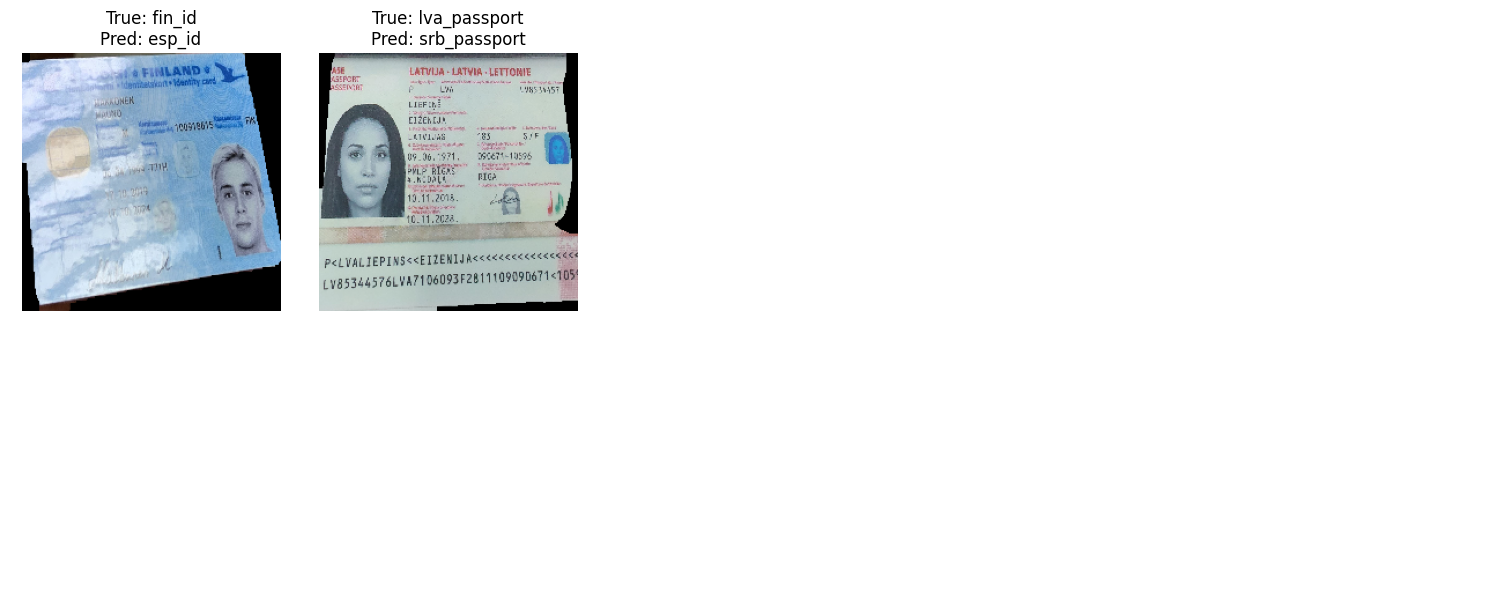

In [21]:
# Visualize misclassified samples
visualize_misclassified_samples(model, data['test_loader'], class_names, device)

## 11. Inference on Single Image

Let's see how we can use our trained model to classify a single image.

True class: srb_passport


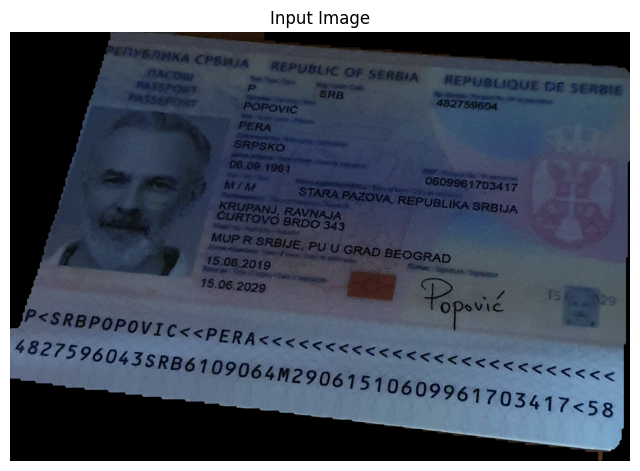

Top 3 predictions:
srb_passport: 93.98%
aze_passport: 4.34%
est_id: 0.72%


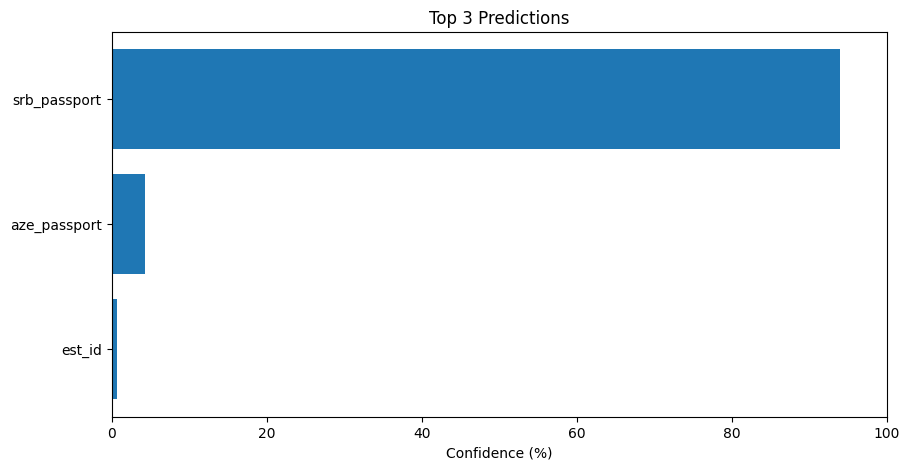

In [22]:
def predict_single_image(model, image_path, transform, class_names, device):
    """
    Predict class for a single image and visualize the result.
    
    Args:
        model: Trained PyTorch model
        image_path: Path to the image file
        transform: Transformation pipeline for inference
        class_names: List of class names
        device: Device to run inference on
    """
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display original image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')
    plt.show()
    
    # Apply transformations
    transformed = transform(image=image)
    image_tensor = transformed['image']
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension
    
    # Set model to evaluation mode
    model.eval()
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        values, indices = torch.topk(probabilities, 3)  # Get top 3 predictions
    
    # Display prediction results
    values = values.squeeze().cpu().numpy() * 100  # Convert to percentage
    indices = indices.squeeze().cpu().numpy()
    
    print("Top 3 predictions:")
    for i in range(min(3, len(class_names))):
        print(f"{class_names[indices[i]]}: {values[i]:.2f}%")
    
    # Create a horizontal bar chart for visualization
    plt.figure(figsize=(10, 5))
    plt.barh(y=[class_names[idx] for idx in indices[:3]], width=values[:3])
    plt.xlabel('Confidence (%)')
    plt.title('Top 3 Predictions')
    plt.xlim(0, 100)
    plt.gca().invert_yaxis()  # Highest confidence at the top
    plt.show()

# Get a test image for inference
test_dataset = data['test_dataset']
test_idx = np.random.randint(0, len(test_dataset))
test_image_path = test_dataset.image_paths[test_idx]
test_label = test_dataset.labels[test_idx]

# Use validation/test transform for inference (no augmentation)
inference_transform = transforms_dict['test']

# Run inference on the test image
print(f"True class: {class_names[test_label]}")
predict_single_image(model, test_image_path, inference_transform, class_names, device)

## 12. Saving the model

In [24]:
import json

# Define paths
model_name = "custom_cnn_model"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure directory exists
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Paths
save_path_pt = os.path.join(CHECKPOINT_DIR, f"{model_name}_scripted.pt")
save_path_metadata = os.path.join(CHECKPOINT_DIR, f"{model_name}_metadata.json")

# Save metadata separately as JSON
metadata = {
    "class_names": class_names,
    "num_classes": num_classes,
    "img_size": IMG_SIZE,
    "metrics": {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in test_metrics.items()}
}

with open(save_path_metadata, 'w') as f:
    json.dump(metadata, f)
print(f"📄 Metadata saved separately at: {save_path_metadata}")

# Save TorchScript `.pt` format (for optimized inference)
scripted_model = torch.jit.trace(model, torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device))
torch.jit.save(scripted_model, save_path_pt)
print(f"Model saved in TorchScript format at: {save_path_pt}")

📄 Metadata saved separately at: ..\..\web-app\backend\models\custom_cnn_model_metadata.json
Model saved in TorchScript format at: ..\..\web-app\backend\models\custom_cnn_model_scripted.pt
